## Problem Set #3

MACS 30100, Dr. Evans
<br>
Due Wednesday, Jan. 24 at 11:30am
<br>
Liqiang Yu

### Problem 1

Some income data, lognormal distribution, and GMM

(a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

<IPython.core.display.Javascript object>


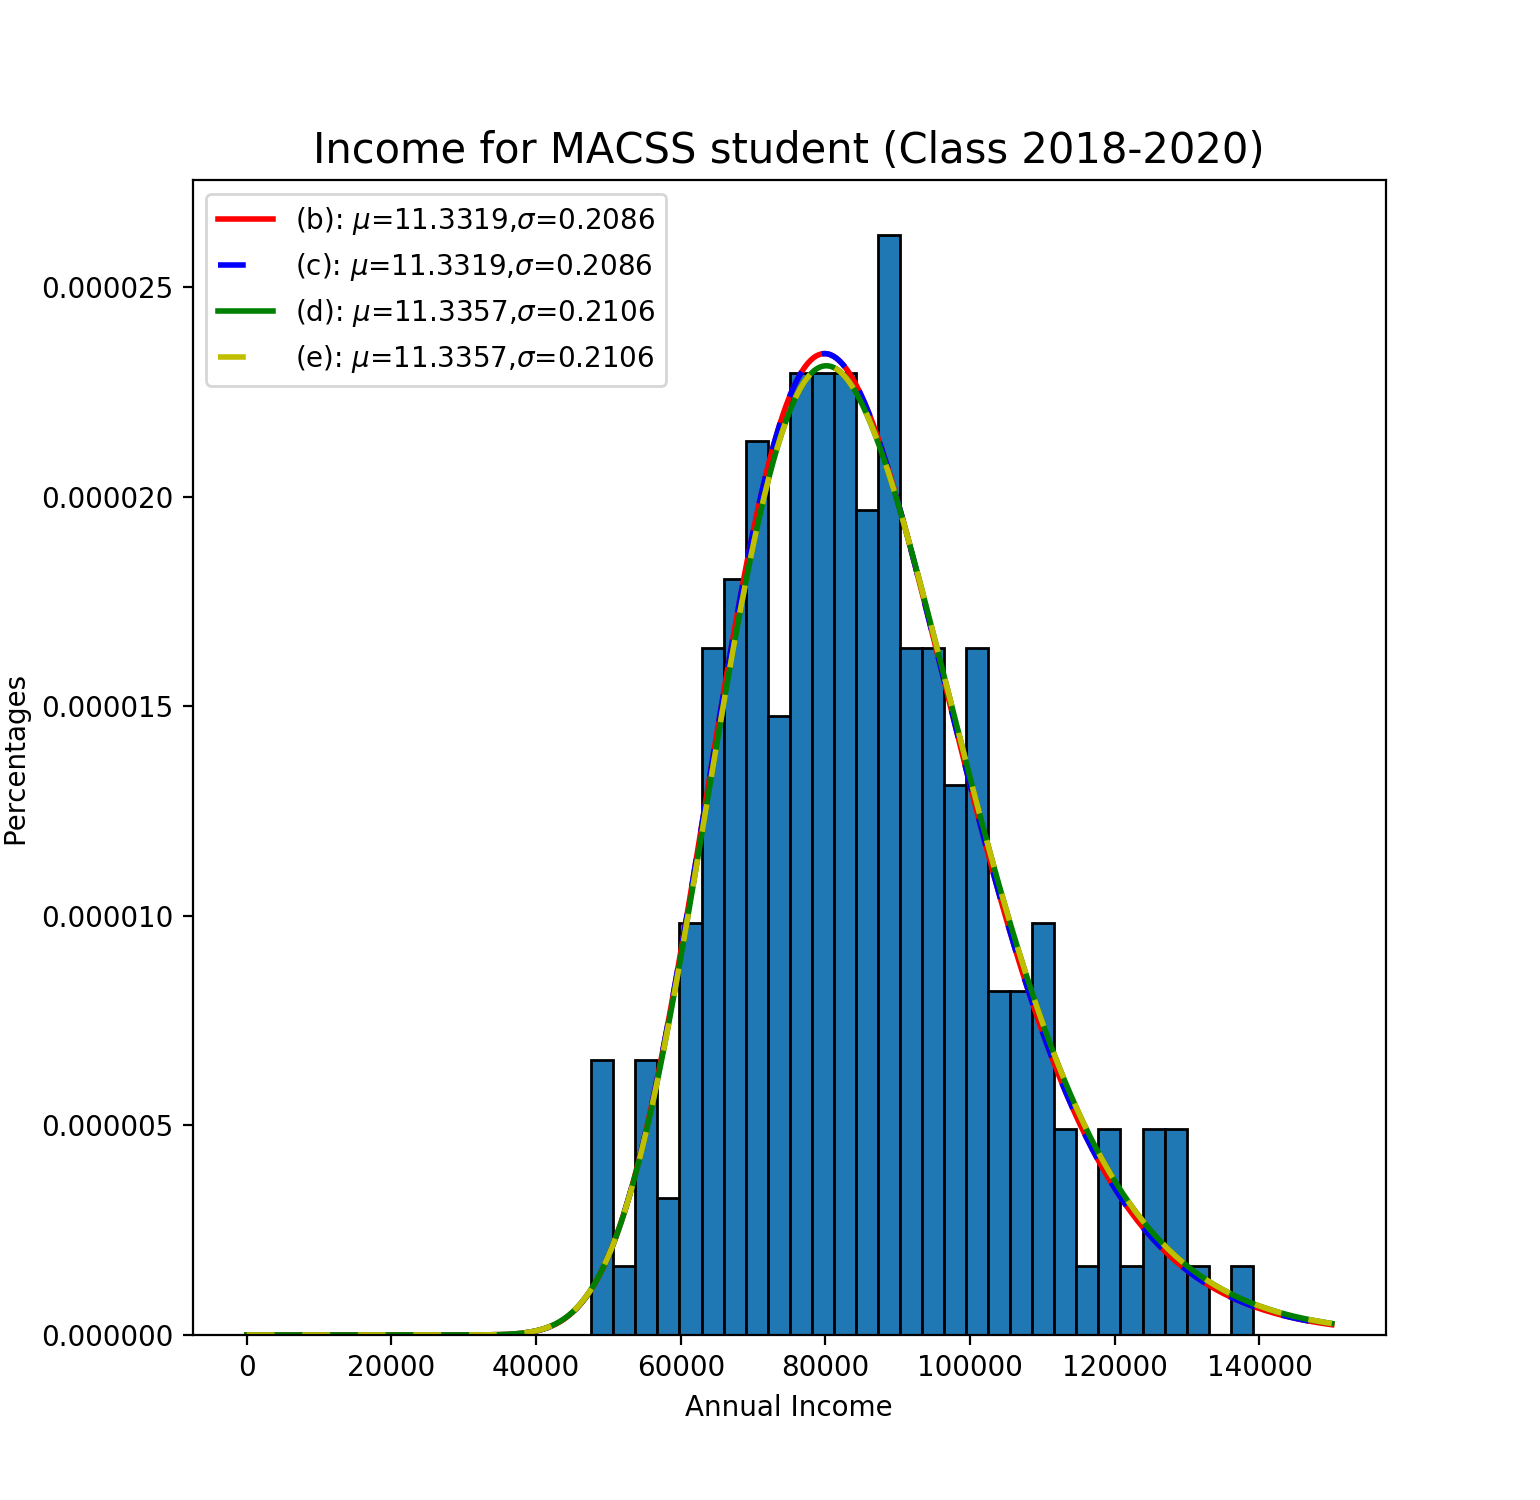

In [175]:
import numpy as np
import scipy.stats as sts
import math
import matplotlib.pyplot as plt

%matplotlib notebook
fig, ax = plt.subplots(figsize=(7.7, 7.5))
income = np.loadtxt('incomes.txt')
plt.hist(income, 30, edgecolor='black',normed=True)
plt.title('Income for MACSS student (Class 2018-2020)', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percentages')

The histogram is given above with bins weighted (normed = True).

(b) Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix W . Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.

In [176]:
import scipy.integrate as intgr
import scipy.optimize as opt
import numpy.linalg as lin

def lgnorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and standard
    deviation sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals_ln = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals_ln
    --------------------------------------------------------------------
    '''
    pdf_vals_ln = (1/(xvals * sigma * np.sqrt(2 * np.pi)) * np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma**2)))
    return pdf_vals_ln

def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    std_data  = scalar > 0, standard deviation of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
    np.exp() 
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    var_model  = scalar > 0, variance of test scores from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    mean_model = np.exp(mu + sigma * sigma / 2)
    std_model = np.sqrt(np.exp(2 * mu + sigma * sigma) * (np.exp(sigma * sigma) - 1))
    
    return mean_model, std_model

def err_vec(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    std_data   = scalar > 0, std of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, std from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [177]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x

In [178]:
x = np.linspace(0.001, 150000.0, 500)
plt.plot(x, lgnorm_pdf(x, mu_GMM1, sig_GMM1), linewidth = 2, color = 'r',label='(b): $\mu$=11.3319,$\sigma$=0.2086')
plt.legend(loc='upper left')

In [179]:
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print('Value of GMM criterion function= ', results.fun[0])
print('Error= ', err_vec(income, mu_GMM1, sig_GMM1))
print('Data mean, data standard deviation = ', data_moments(income))
print('Model mean, model standard deviation = ', model_moments(mu_GMM1, sig_GMM1))

mu_GMM1= 11.3318807729  sig_GMM1= 0.208696666481
Value of GMM criterion function=  [  6.99496828e-15]
Error=  [[ -6.98440504e-08]
 [ -4.60084439e-08]]
Data mean, data standard deviation =  (85276.823606258113, 17992.542128046523)
Model mean, model standard deviation =  (85276.81765017935, 17992.541300237659)


So the GMM method gives mu_GMM1= 11.3318807729 and sig_GMM1= 0.208696666481. The lognormal PDF curve is given in the same graph above. The value of GMM criterion function at the estimated parameter values is 6.99496828e-15. The data mean is 85276.823606258113, which is close to model mean (85276.81765017935). The data standard deviation is 17992.542128046523, while the model standard deviation is 17992.541300237659.

(c) Perform the two-step GMM estimator by using your estimates from part
(b) with two moments to generate an estimator for the variance covariance matrix Ω 2step , which you then use to get the two-step estimator for the optimal weighting matrix W 2step . Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b). Report and compare your two data moments against your two model moments at the estimated parameter values.

In [180]:
err1 = err_vec(income, mu_GMM1, sig_GMM1)
VCV2 = np.dot(err1, err1.T) / income.shape[0]

W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned

In [181]:
params_init = np.array([mu_GMM1, sig_GMM1]) #Using results from a as initial values
gmm_args = (income, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x

In [182]:
print("2 step VCV matrix is",VCV2)
print("W matrix is",W_hat2)
print('Estimates are mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
print('Value of GMM criterion function= ', results2.fun[0])
print('Data mean, data standard deviation = ', data_moments(income))
print('Model mean, model standard deviation = ', model_moments(mu_GMM2, sig_GMM2))
plt.plot(x, lgnorm_pdf(x, mu_GMM2, sig_GMM2), linewidth = 2,dashes = [5, 5, 5, 5], color = 'b',label='(c): $\mu$=11.3319,$\sigma$=0.2086')
plt.legend(loc='upper left')

2 step VCV matrix is [[  2.43909569e-17   1.60670804e-17]
 [  1.60670804e-17   1.05838845e-17]]
W matrix is [[  1.99396408e+16   1.31348603e+16]
 [  1.31348603e+16   8.65234018e+15]]
Estimates are mu_GMM2= 11.3318807729  sig_GMM2= 0.208696666481
Value of GMM criterion function=  [  2.53627630e-05]
Data mean, data standard deviation =  (85276.823606258113, 17992.542128046523)
Model mean, model standard deviation =  (85276.81765017935, 17992.541300237659)


So the GMM method gives the same estimate that mu_GMM2= 11.3318807729 and sig_GMM2= 0.208696666481. The value of GMM criterion function at the estimated parameter values is 2.53627630e-05. The lognormal PDF curve is given in the same graph above in dashed blue line.  The data mean is 85276.823606258113, which is close to model mean (85276.81765017935). The data standard deviation is 17992.542128046523, while the model standard deviation is 17992.541300237659. Using a better weighting matrix didn't improve our estimates or fit very much. This means that we did not choose good moments for fitting the data.

(d) Now estimate the lognormal PDF to ﬁt the data by GMM using diﬀerent moments. Use percent of individuals who earn less than \$75,000, percent of individuals who earn between \$75,000 and \$100,000, and percent of individuals who earn more than \$100,000 as your three moments. Use the identity matrix as your estimator for the optimal weighting matrix. Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

In [183]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 10000 <= x 


    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals > 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable

    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
    sts.norm.cdf(x, loc = mu, scale = sigma)
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3

    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    
    bpct_1_mod = sts.norm.cdf(np.log(75000), loc = mu, scale = sigma)
    bpct_2_mod = sts.norm.cdf(np.log(100000), loc = mu, scale = sigma) - bpct_1_mod
    bpct_3_mod = 1- sts.norm.cdf(np.log(100000), loc = mu, scale = sigma)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments3()
        model_moments3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [184]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat3 = np.eye(3)
gmm_args = (income, W_hat3)
results3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results3.x

In [185]:
x = np.linspace(0.001, 150000.0, 500)
plt.plot(x, lgnorm_pdf(x, mu_GMM3, sig_GMM3), linewidth = 2, color = 'g',label='(d): $\mu$=11.3357,$\sigma$=0.2106')
plt.legend(loc='upper left')
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)
print('Value of GMM criterion function= ', results3.fun[0])
print('Error= ', err_vec3(income, mu_GMM3, sig_GMM3))
print('Data moments = ', data_moments3(income))
print('Model moments = ', model_moments3(mu_GMM3, sig_GMM3))

mu_GMM3= 11.3356813274  sig_GMM3= 0.210598453721
Value of GMM criterion function=  [  2.53378840e-11]
Error=  [[  1.21088896e-06]
 [  1.17086321e-06]
 [ -4.74349146e-06]]
Data moments =  (0.3, 0.5, 0.2)
Model moments =  (0.30000000363266688, 0.50000000585431603, 0.19999999051301709)


The new GMM method with new moments gives mu_GMM3= 11.3356813274 and sig_GMM3= 0.210598453721. The lognormal PDF curve is given in the same graph above. The value of GMM criterion function at the estimated parameter values is 2.53378840e-11. The data moments are (0.3, 0.5, 0.2) while the model moments are (0.30000000363266688, 0.50000000585431603, 0.19999999051301709). Three data moments are close to
three model moments.

In [186]:
err3 = err_vec3(income, mu_GMM3, sig_GMM3)
VCV3 = np.dot(err3, err3.T) / income.shape[0]

W_hat3 = lin.pinv(VCV3)

In [187]:
params_init = np.array([mu_GMM3, sig_GMM3]) #Using results from a as initial values
gmm_args = (income, W_hat3)
results4 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results4.x

In [188]:
print("2 step VCV matrix is",VCV3)
print("W matrix is",W_hat3)
print('Estimates are mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)
print('Value of GMM criterion function= ', results4.fun[0])
print('Data moments = ', data_moments3(income))
print('Model moments = ', model_moments3(mu_GMM4, sig_GMM4))
plt.plot(x, lgnorm_pdf(x, mu_GMM4, sig_GMM4), linewidth = 2,dashes = [5, 5, 5, 5], color = 'y',label='(e): $\mu$=11.3357,$\sigma$=0.2106')
plt.legend(loc='upper left')

2 step VCV matrix is [[  7.33126041e-15   7.08892667e-15  -2.87192073e-14]
 [  7.08892667e-15   6.85460324e-15  -2.77698981e-14]
 [ -2.87192073e-14  -2.77698981e-14   1.12503556e-13]]
W matrix is [[  4.56770398e+11   4.41671920e+11  -1.78933540e+12]
 [  4.41671920e+11   4.27072520e+11  -1.73018918e+12]
 [ -1.78933540e+12  -1.73018918e+12   7.00947604e+12]]
Estimates are mu_GMM4= 11.3356813287  sig_GMM4= 0.210598455304
Value of GMM criterion function=  [ 83.22328503]
Data moments =  (0.3, 0.5, 0.2)
Model moments =  (0.30000000297023366, 0.50000000310877635, 0.19999999392098999)


Using two-step, we get the same results as in part (d). Data moments are (0.3, 0.5, 0.2) and model moments are (0.30000000297023366, 0.50000000310877635, 0.19999999392098999). Three data moments are close to
three model moments.

(f) Which of the four estimations from parts (b), (c), (d), and (e) ﬁts the data best? Justify your answer.

There is little difference between all four models as they are the optimal solution under a specific criteria. However, I would say (b) fits the data best. For one reason, the choice of moments in part (d) is somewhat arbitrary, which means that we could easily get a bad fitting when using a bad choice of moments. For the other, there is no need to calculate the weighting matrix for this model, thus saving a lot of computational resources. Last but not the least, model in (b) is better in terms of robustness.

### Problem 2

(a) Report your estimates and report the value of your GMM criterion function. In this case, the GMM criterion function value evaluated at the optimal parameter values is simply the sum of squared errors.

In [189]:
sick = np.loadtxt("sick.txt", skiprows = 1,delimiter  = ',')
sick_week = sick[:,0]
sick_age = sick[:,1]
sick_children = sick[:,2]
sick_avg_tem = sick[:,3]

In [190]:
def LR_data_moment(xvals):
    return xvals

def LR_model_moment(s_age, s_children, s_avg_tem, param):
    beta_0, beta_1, beta_2, beta_3 = param
    resd = beta_0 + beta_1 * s_age + beta_2 * s_children + beta_3 * s_avg_tem
    return resd

def LR_err(xvals, s_age, s_children, s_avg_tem, param, W):
    dm = LR_data_moment(xvals)
    mm = LR_model_moment(s_age, s_children, s_avg_tem, param)
    err = (dm - mm) 
    return err.T @ W @ err

def LR_criterion(params, *args):
    param = params
    s_week, s_age, s_children, s_avg_tem, W = args
    return LR_err(s_week, s_age, s_children, s_avg_tem, param, W)

In [191]:
param_init = np.array([0,1,1,1])
W_LR = np.eye(len(sick_week))
res_LR = opt.minimize(LR_criterion, param_init, args=(sick_week, sick_age, sick_children, sick_avg_tem, W_LR), \
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, None)))

In [192]:
print("Beta_0 to beta_3 are:",res_LR.x)
print("Value of criterion function :",res_LR.fun)

Beta_0 to beta_3 are: [ 0.25164474  0.01293345  0.40050118 -0.0099917 ]
Value of criterion function : 0.00182128981732


The estimated parameters are $\beta_0$ = 0.2516, $\beta_1$ = 0.0129, $\beta_2$ = 0.4005, $\beta_3$ = -0.0099, which are the same as we got in PS2. The value of the criterion function at this set of parameters is 0.00182128981732.